---
title: "Variational AutoEncoders in PyTorch"
author: "Daniel J Smith"
date: "2024-04-14"
categories: [Python, ML, Deep Learning, PyTorch]
title-block-banner: false
jupyter: python3
image: 'vae.png'
draft: false
description: "Variational AutoEncoders (VAEs) are implemented in PyTorch. The focus is on the implementation and comparison of VAEs with either 1 or 2 hidden layers in the encoder and decoder. The VAEs are trained on the MNIST dataset and are then used to generate new examples of handwritten digits."
---

In [3]:
import torch
from torch import nn

import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm   # Progress Bar
from utils import versions

In [4]:
versions()

+-------------+------------+
|  Component  |  Version   |
+-------------+------------+
|    Python   |   3.12.2   |
+-------------+------------+
|   pytorch   | 2.2.2+cpu  |
+-------------+------------+
| torchvision | 0.17.2+cpu |
+-------------+------------+


# Variational AutoEncoders (VAEs)

Variational AutoEncoders (VAEs) are a type of generative model designed to capture the underlying probability distribution of a given dataset and generate novel samples. They utilize an architecture that comprises of an encoder-decoder structure:

<img src="vae.png" style="width:75%">

In a nutshell, a VAE is an autoencoder whose encodings distribution is regularised during the training to ensure that its latent space has good properties allowing us to generate some new data. The term “variational” comes from the close relation there is between the regularisation and the variational inference method in statistics.

VAEs tackle the problem of the latent space irregularity by making the encoder return a distribution over the latent space instead of a single point and by adding in the loss function a regularisation term over that returned distribution in order to ensure a better organisation of the latent space.

For more details see the VAE wikipedia page:

> [https://en.wikipedia.org/wiki/Variational_autoencoder](https://en.wikipedia.org/wiki/Variational_autoencoder)


In this post we implement a 1 and 2 hidden layer VAE in PyTorch trained on the MNIST dataset and use the trained models to generate novel examples of handwritten digits.

# Single-Hidden-Layer VAE

In [3]:
#| code-fold: show

class VariationalAutoEncoder(nn.Module):
    """
    A Variational AutoEncoder (VAE) with a single hidden layer in the encoder and decoder.

    Args:
    input_dim (int): The dimension of the input data.
    h_dim (int, optional): The dimension of the hidden layer. Defaults to 200.
    z_dim (int, optional): The dimension of the latent space. Defaults to 20.
    """
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # Encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2logvar = nn.Linear(h_dim, z_dim)

        # Decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        """
        Encodes the input into a distribution over the latent space.

        Args:
        x (Tensor): The input data.

        Returns:
        tuple of Tensor: The mean and log variance of the latent distribution.
        """
        h = self.relu(self.img_2hid(x))
        mu, logvar = self.hid_2mu(h), self.hid_2logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Generates a latent vector by reparameterization.

        Args:
        mu (Tensor): The mean of the latent distribution.
        logvar (Tensor): The log variance of the latent distribution.

        Returns:
        Tensor: The latent vector.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        """
        Decodes a latent vector into the input space.

        Args:
        z (Tensor): The latent vector.

        Returns:
        Tensor: The decoded data.
        """
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        """
        Performs a forward pass through the model.

        Args:
        x (Tensor): The input data.

        Returns:
        tuple of Tensor: The decoded data, mean and log variance of the latent distribution.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
# Configuration
# Set the device for computation, prefer GPU (cuda) if available, else use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The dimension of the input data. For MNIST, images are 28x28 pixels, so the input dimension is 784.
INPUT_DIM = 784

# The dimension of the hidden layer in the VAE.
H_DIM = 200

# The dimension of the latent space in the VAE. This is the dimension of the random variable z in the VAE.
Z_DIM = 50

# The number of epochs to train the model. An epoch is one complete pass through the entire training dataset.
NUM_EPOCHS = 10

# The number of samples per batch. The model parameters are updated once per batch.
BATCH_SIZE = 32

# The learning rate for the Adam optimizer.
LR = 3e-4

## Initialising Single-Layer VAE model

In [5]:
# Initialise Model
# Create an instance of the VariationalAutoEncoder class with the specified input, hidden, and latent dimensions.
# The model is moved to the specified device (either CPU or GPU) for computation.
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)

# Optimizer
# The Adam optimizer is used for updating the parameters of the model.
# The learning rate (LR) is a hyperparameter that controls how much the weights of the network will change in response to the gradient.
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Loss Function
# The Binary Cross Entropy (BCE) loss function is used as the reconstruction loss for the VAE.
# This loss function measures the error between the reconstructed image and the original image.
# The 'sum' reduction mode is used, which means the losses are summed over all elements in the output.
loss_fn = nn.BCELoss(reduction="sum")

## The Dataset

### MNIST

The **MNIST dataset** is a large database of handwritten digits that is commonly used for training various image processing systems. It contains **60,000 training images** and **10,000 testing images**. Each image is a grayscale 28x28 pixel representation of a digit.

<img src="OIP.jpg">

For more details see the MNIST wikipedia page:

> [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)

### Data Loading

The dataset is loaded from a local directory named `dataset/`. If the dataset is not available in this directory, it will be downloaded. The images from the dataset are transformed into tensors using the `transforms.ToTensor()` function from PyTorch. This converts the images from a PIL Image or numpy `ndarray` into tensor format.

After loading the dataset, we use PyTorch's `DataLoader` to shuffle and batch the data. Shuffling the data ensures that the model's performance is not affected by the order of the data in the dataset. The `batch_size` parameter for the DataLoader is set to `BATCH_SIZE`.

In [6]:
# Dataset loading
# Load the MNIST dataset. If it's not available in the local directory, download it.
# The images are transformed to tensors using transforms.ToTensor().
dataset = datasets.MNIST(root="dataset/",
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

# DataLoader is used to shuffle and batch the data.
# Shuffling helps to make sure that the model is not affected by the order of the data in the dataset.
train_loader = DataLoader(dataset=dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 5711216.86it/s]


Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28869326.46it/s]


Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6409941.87it/s]


Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



## Training

### Training Function `train_vae`

The `train_vae` function is implemented and used to train the VAE model.

>  **Training Loop**:
>
>    - The model is set to training mode at the start.
>
>    - For each epoch, the function initializes the total loss for the epoch (`epoch_loss`).
>
>    - It then loops over the training data. For each batch, it performs a forward pass, computes the loss, performs backpropagation, and updates the model parameters.
> <br>
>
> **Loss Function**:
>
>    - The loss function consists of two parts: the reconstruction loss and the Kullback-Leibler (KL) divergence.
>
>    - The **reconstruction loss** (`reconstruction_loss`) measures how well the model can reconstruct the input.
>
>    - The **KL divergence** (`kl_div`) measures how much the latent distribution deviates from a standard normal distribution. It is computed as `-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())`.

For a precise definition of the KL divergence, see my previous blog post: 

>  ["The Boltzmann Equation - 3. Information Theory"](https://danieljamessmith.github.io/blog/posts/bte3/#definition-2.2.1---kl-divergence)

In [7]:
#| code-fold: show

def train_vae(model, train_loader, optimizer, loss_fn, num_epochs, device):
    """
    Train a Variational AutoEncoder (VAE) model.

    Args:
    model (nn.Module): The VAE model.
    train_loader (DataLoader): The DataLoader for the training data.
    optimizer (Optimizer): The optimizer for the model.
    loss_fn (Loss): The loss function to use.
    num_epochs (int): The number of epochs to train for.
    device (torch.device): The device to train the model on.
    """
    # Ensure model is in training mode
    model.train()

    # Start Training
    for epoch in range(num_epochs):
        # Initialize the loss for this epoch
        epoch_loss = 0.0

        # tqdm is used to show a progress bar for the training loop
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
        for i, (x, _) in loop:
            # Forward Pass:
            # Move the input to the device and reshape it
            x = x.to(device).view(x.shape[0], -1)
            # Pass the input through the model to get the reconstructed output and the parameters of the latent distribution
            x_reconstructed, mu, logvar = model(x)

            # Compute Loss:
            # Compute the reconstruction loss (how well the model can reconstruct the input)
            reconstruction_loss = loss_fn(x_reconstructed, x)
            # Compute the KL divergence loss (how much the latent distribution deviates from a standard normal distribution)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Backpropagation:
            # Compute the total loss, perform backpropagation to compute gradients, and update the model parameters
            loss = reconstruction_loss + kl_div 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add the loss for this batch to the total loss for this epoch
            epoch_loss += loss.item()

            # Update the progress bar with the current loss
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=epoch_loss / (i+1))

    print("Training completed.")

In [8]:
train_vae(model, train_loader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [10/10]: 100%|██████████| 1875/1875 [00:21<00:00, 86.45it/s, loss=3.52e+3]

Training completed.


## Visualising Results

In [9]:
#| code-fold: show

def inference(model, digit, num_examples=1, plot=False):
    """
    Generate `num_examples` of the specified `digit` using the provided VAE `model`.

    Args:
    model (nn.Module): The Variational AutoEncoder model.
    digit (int): The digit to generate (0-9).
    num_examples (int, optional): The number of examples to generate. Defaults to 1.
    plot (bool, optional): Whether to plot the generated images. Defaults to False.

    Returns:
    list of Tensor: The generated images.
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Extract an example of the specified digit from the dataset
    image = None
    for x, y in train_loader.dataset:
        if y == digit:
            image = x
            break

    # Get the mean and logvar for the specified digit
    mu, logvar = model.encode(image.view(1, 784).to(DEVICE))

    # Create a list to store the output images
    out_images = []

    for example in range(num_examples):
        # Create a latent vector
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(DEVICE)
        z = mu + eps * std

        # Decode the latent vector
        with torch.no_grad():
            out = model.decode(z)

        # Reshape the output and move it to CPU
        out = out.view(-1, 1, 28, 28).cpu()

        # Add the output image to the list
        out_images.append(out)

        # Plot the image if plot is True
        if plot:
            plt.imshow(out[0].detach().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.show()
            return None

    return out_images


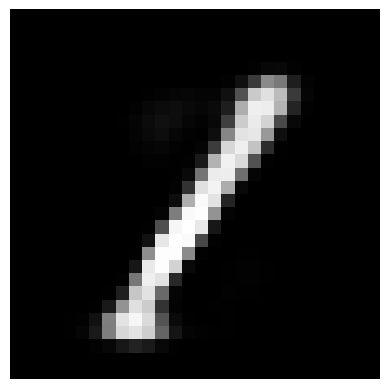

In [10]:
inference(model, digit=1, plot=True)

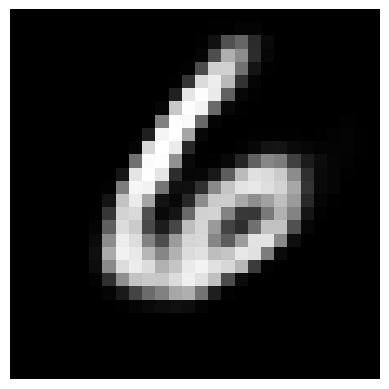

In [11]:
inference(model, digit=6, plot=True)

In [12]:
#| code-fold: show

def visualise_digits(model):
    """
    Generate and plot an example of each digit (0-9) using the provided VAE `model`.

    Args:
    model (nn.Module): The Variational AutoEncoder model.
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Create a subplot for each digit in a 5x2 grid
    fig, axs = plt.subplots(5, 2, figsize=(5, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0)

    for digit in range(10):
        # Generate an example of the digit
        out_images = inference(model, digit, num_examples=1)

        # Display the output image with a title
        ax = axs[digit // 2, digit % 2]
        ax.imshow(out_images[0][0].detach().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Generated Digit: {digit}')

    plt.show()

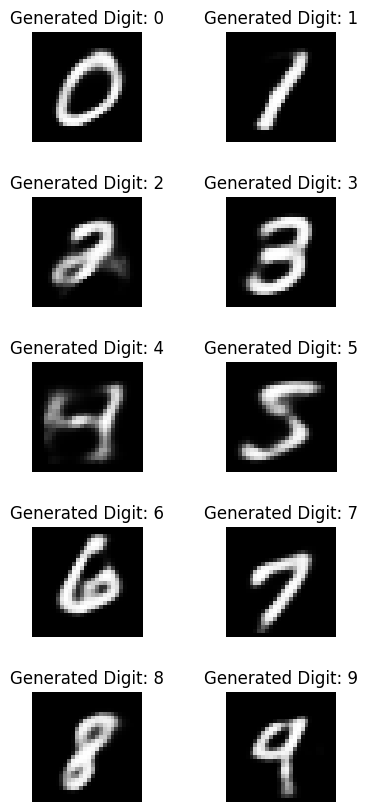

In [13]:
visualise_digits(model)

# Double-Hidden-Layer VAE

In [14]:
#| code-fold: show

class VariationalAutoEncoder_nlayers(nn.Module):
    """
    A Variational AutoEncoder (VAE) with a configurable number of hidden layers.

    Args:
    input_dim (int): The dimension of the input data.
    h_dim1 (int, optional): The dimension of the first hidden layer. Defaults to 400.
    h_dim2 (int, optional): The dimension of the second hidden layer. Defaults to 200.
    z_dim (int, optional): The dimension of the latent space. Defaults to 20.
    num_layers (int, optional): The number of hidden layers in the encoder and decoder (1 or 2). Defaults to 1.
    """
    def __init__(self, input_dim, h_dim1=400, h_dim2=200, z_dim=20, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        # Encoder
        self.img_2hid1 = nn.Linear(input_dim, h_dim1)
        if num_layers == 2:
            self.hid1_2hid2 = nn.Linear(h_dim1, h_dim2)
            self.hid2_2mu = nn.Linear(h_dim2, z_dim)
            self.hid2_2logvar = nn.Linear(h_dim2, z_dim)
        else:
            self.hid2_2mu = nn.Linear(h_dim1, z_dim)
            self.hid2_2logvar = nn.Linear(h_dim1, z_dim)

        # Decoder
        if num_layers == 2:
            self.z_2hid2 = nn.Linear(z_dim, h_dim2)
            self.hid2_2hid1 = nn.Linear(h_dim2, h_dim1)
        else:
            self.z_2hid2 = nn.Linear(z_dim, h_dim1)
        self.hid1_2img = nn.Linear(h_dim1, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        """
        Encodes the input into a distribution over the latent space.

        Args:
        x (Tensor): The input data.

        Returns:
        tuple of Tensor: The mean and log variance of the latent distribution.
        """
        h1 = self.relu(self.img_2hid1(x))
        if self.num_layers == 2:
            h2 = self.relu(self.hid1_2hid2(h1))
            mu, logvar = self.hid2_2mu(h2), self.hid2_2logvar(h2)
        else:
            mu, logvar = self.hid2_2mu(h1), self.hid2_2logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Generates a latent vector by reparameterization.

        Args:
        mu (Tensor): The mean of the latent distribution.
        logvar (Tensor): The log variance of the latent distribution.

        Returns:
        Tensor: The latent vector.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        """
        Decodes a latent vector into the input space.

        Args:
        z (Tensor): The latent vector.

        Returns:
        Tensor: The decoded data.
        """
        if self.num_layers == 2:
            h2 = self.relu(self.z_2hid2(z))
            h1 = self.relu(self.hid2_2hid1(h2))
        else:
            h1 = self.relu(self.z_2hid2(z))
        return torch.sigmoid(self.hid1_2img(h1))

    def forward(self, x):
        """
        Performs a forward pass through the model.

        Args:
        x (Tensor): The input data.

        Returns:
        tuple of Tensor: The decoded data, mean and log variance of the latent distribution.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Hyperparameters

In [15]:
# Configuration
# Set the device for computation, prefer GPU (cuda) if available, else use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The dimension of the input data. For MNIST, images are 28x28 pixels, so the input dimension is 784.
INPUT_DIM = 784

# The dimension of the first hidden layer in the VAE.
H_DIM1 = 400

# The dimension of the second hidden layer in the VAE.
H_DIM2 = 200

# The dimension of the latent space in the VAE. This is the dimension of the random variable z in the VAE.
Z_DIM = 50

# The number of epochs to train the model. An epoch is one complete pass through the entire training dataset.
NUM_EPOCHS = 10

# The number of samples per batch. The model parameters are updated once per batch.
BATCH_SIZE = 32

# The learning rate for the Adam optimizer.
LR = 3e-4

## Initialising Double-Layer VAE model

In [16]:
# Initialise Model
# Create an instance of the VariationalAutoEncoder_nlayer class with the specified input, hidden, and latent dimensions. Set num_layers=2.
# The model is moved to the specified device (either CPU or GPU) for computation.
model_2layers = VariationalAutoEncoder_nlayers(INPUT_DIM, 
                                               H_DIM1, 
                                               H_DIM2, 
                                               Z_DIM, 
                                               num_layers=2).to(DEVICE)

# Optimizer
# The Adam optimizer is used for updating the parameters of the model.
# The learning rate (LR) is a hyperparameter that controls how much the weights of the network will change in response to the gradient.
optimizer = torch.optim.Adam(model_2layers.parameters(), lr=LR)

# Loss Function
# The Binary Cross Entropy (BCE) loss function is used as the reconstruction loss for the VAE.
# This loss function measures the error between the reconstructed image and the original image.
# The 'sum' reduction mode is used, which means the losses are summed over all elements in the output.
loss_fn = nn.BCELoss(reduction="sum")

## Training

Using the `train_vae` model as defined for the Single-Hidden-Layer VAE model:

In [17]:
train_vae(model_2layers, train_loader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

Epoch [10/10]: 100%|██████████| 1875/1875 [00:28<00:00, 64.87it/s, loss=3.35e+3]

Training completed.


## Visualing Results

Using the `inference` and `visualize_digits` functions as defined for the Single-Hidden-Layer VAE model:

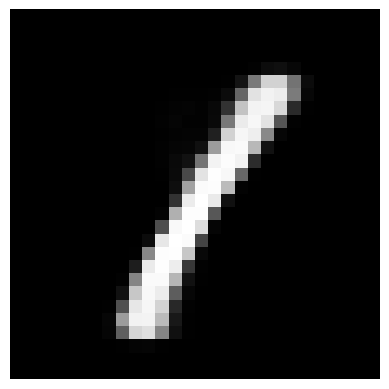

In [18]:
inference(model_2layers, digit=1, plot=True)

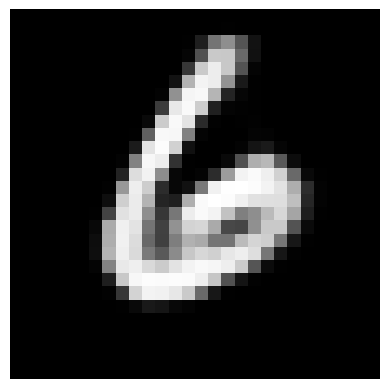

In [19]:
inference(model_2layers, digit=6, plot=True)

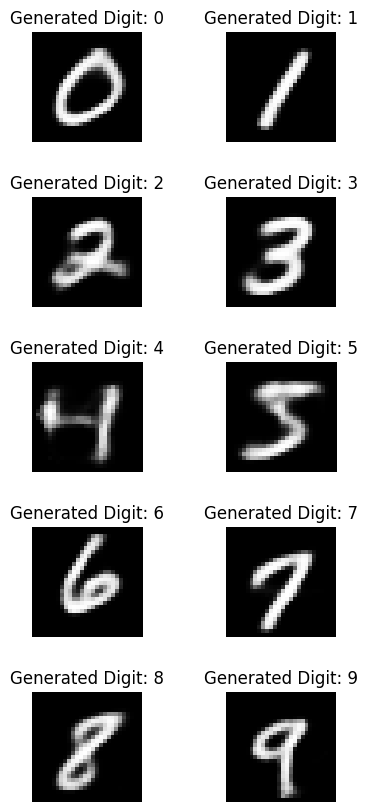

In [20]:
visualise_digits(model_2layers)

# Remarks and Further Directions

> - The generated images of the digits are slightly sharper and more interpretable when the encoder & decoder have 2 hidden layers compared to 1 hidden layer. This is because a model with more hidden layers is more expressible and is able to capture more complex patterns in the training data.
> <br>
> - Further improvements could be seen by tuning the hyperparameters of the models such as the learning rate `LR` and the batch size `BATCH_SIZE`.
> <br>
> - Adding regularization e.g. through dropout layers and/or regularization terms in the loss function would result in more generalisable models.